In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

In [3]:
load_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_pkl'
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_pkl_canonical_3d_fixed_dist_5'
if not os.path.exists(save_folder): os.makedirs(save_folder)

In [4]:
overwrite = False
for item in tqdm(glob(load_folder + '/*.pkl')):
    save_path = item.replace(os.path.basename(load_folder), os.path.basename(save_folder))
    if os.path.exists(save_path) and not overwrite: 
        print('already exists', save_path)
        continue
    data = readpkl(item)
    new_data = {}
    new_data['joint_2d_from_canonical_3d'] = []
    new_data['joint3d_image_from_canonical_3d'] = []
    new_data['world_3d_from_canonical_3d'] = []
    new_data['cam_3d_from_canonical_3d'] = []
    
    cam_param = data['cam_param'][0].reshape(1)[0].copy()
    int_mat = cam_param['intrinsic']
    ext_mat = cam_param['extrinsic']
    cam_proj = int_mat @ ext_mat
    R = ext_mat[:3, :3]
    t = ext_mat[:3, 3]
    C = T_to_C(R, t)
    fx, fy, cx, cy = int_mat[0, 0], int_mat[1, 1], int_mat[0, 2], int_mat[1, 2]
    
    num_frames = len(data['world_3d'])
    world_3d = np.array(data['world_3d']).copy() # (F, J, 3)
    cam_3d = np.array(data['cam_3d']).copy()/1000 # (F, J, 3)
    world_3d_from_canonical_3d = get_canonical_3d(world_3d, cam_3d, C, R, fixed_dist=5, canonical_type='fixed_dist')
    cam_3d_from_canonical_3d = np.einsum('ij,jkl->ikl', R, (world_3d_from_canonical_3d-C).T).T
    img_2d_from_canonical_3d = _weak_project(cam_3d_from_canonical_3d, fx, fy, cx, cy)
        
    new_data['joint_2d_from_canonical_3d'] = list(img_2d_from_canonical_3d.copy())
    #new_data['joint3d_image_from_canonical_3d'] = list(img_3d_from_canonical_3d.copy())
    new_data['cam_3d_from_canonical_3d'] = list(cam_3d_from_canonical_3d.copy())
    
    new_data['joint_2d'] = data['joint_2d'].copy()
    new_data['confidence'] = data['confidence'].copy()
    new_data['camera_name'] = data['camera_name'].copy()
    new_data['action'] = data['action'].copy()
    new_data['source'] = data['source'].copy()
    new_data['frame'] = data['frame'].copy()
    new_data['cam_3d'] = data['cam_3d'].copy()
    new_data['cam_param'] = data['cam_param'].copy()
    savepkl(new_data, save_path)

100%|██████████| 1504/1504 [02:26<00:00, 10.28it/s]


In [18]:
new_data.keys() - data.keys()

{'cam_3d_from_canonical_3d',
 'joint3d_image_from_canonical_3d',
 'joint_2d_from_canonical_3d',
 'world_3d_from_canonical_3d'}

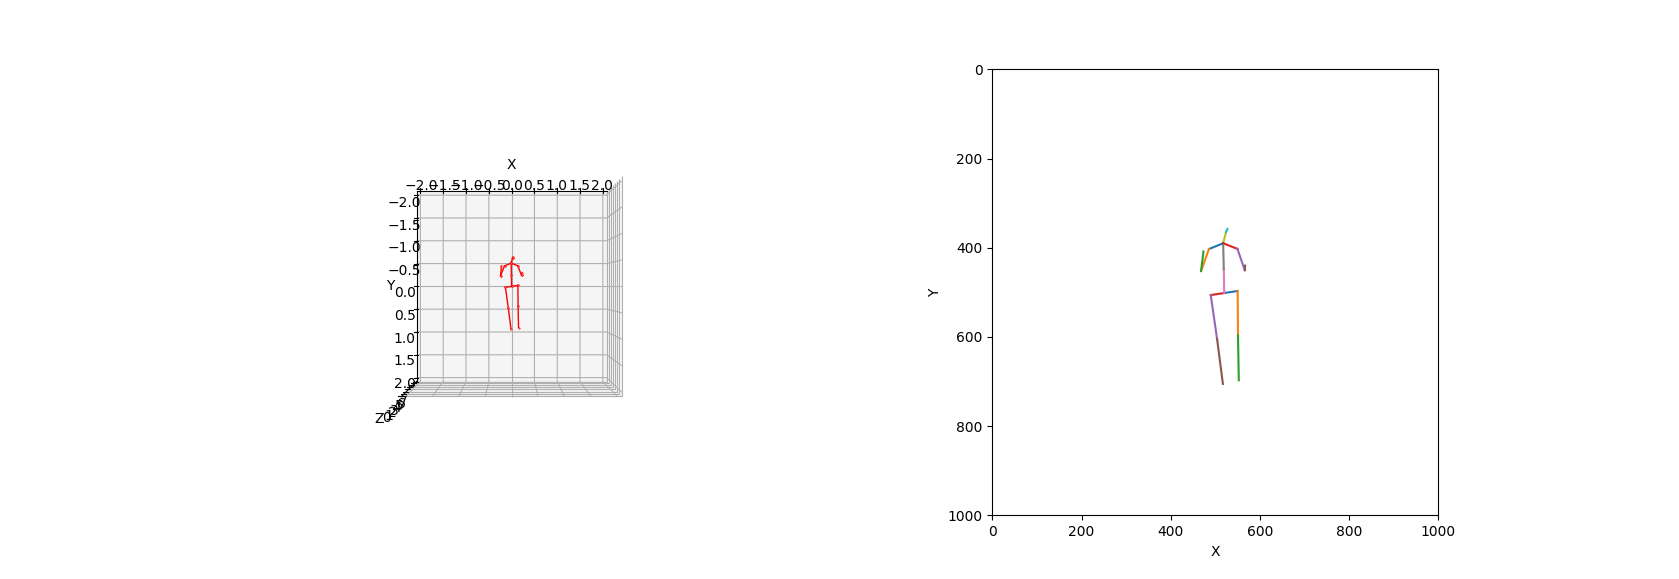

In [21]:
frame_num = -500
cam_3d_from_canonical_3d = new_data['cam_3d_from_canonical_3d'][frame_num]
joint_2d_from_canonical_3d = new_data['joint_2d_from_canonical_3d'][frame_num]

%matplotlib widget
fig = plt.figure(0)
fig.clear()
ax_cam = axes_3d(fig, loc=121, view=(-90,-90), zlim=(0, 7))
#draw_3d_pose(ax, img_3d_hat/1000)
draw_3d_pose(ax_cam, cam_3d_from_canonical_3d, color='r')
ax_2d = axes_2d(fig, loc=122, W=1000, H=1000)
draw_2d_pose(ax_2d, joint_2d_from_canonical_3d)
plt.show()